*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [6]:
import pandas as pd
import os
import networkx as nx
import nltk
import numpy as np
import matplotlib.pyplot as plt
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\astri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
labmt = pd.read_csv("Data_Set_S1.txt", sep='\t', skiprows=3)

word_to_scores = labmt.set_index('word').to_dict(orient='index')

def calculate_sentiment(tokens):
    """
    Calculate average sentiment for a list of tokens based on LabMT word list.
    """
    tokens = [t.lower() for t in tokens]
    
    sentiment_score = 0
    for token in tokens:
        if token in word_to_scores:
            sentiment_score += word_to_scores[token]['happiness_average']
        else:
            sentiment_score += 0
    
    return sentiment_score  

> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.

In [7]:
DATA_DIR = "performers"   
WORD_RE = re.compile(r"\w+")
LINK_RE = re.compile(r"\[\[([^\]|#]+)")  

def file_to_title(fname):
    """Convert filename like 'The_Beatles.txt' -> 'The Beatles'"""
    return fname.replace(".txt", "").replace("_", " ")

def normalize(title):
    """Normalize artist name for comparison"""
    return re.sub(r"[^a-z0-9]+", "", title.lower())

# --- Read all artist files and build name maps ---
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".txt")]
performers = [file_to_title(f) for f in files]
norm2canon = {normalize(t): t for t in performers}

# --- Create a directed graph and fill it ---
graph = nx.DiGraph()
graph.add_nodes_from(performers)

for fname in files:
    src = file_to_title(fname)
    path = os.path.join(DATA_DIR, fname)

    with open(path, "r", encoding="utf-8") as fh:
        text = fh.read()

    # store full text (like your original code)
    graph.nodes[src]["text"] = text
    
    # find outgoing links
    unique_targets = set()
    for raw in LINK_RE.findall(text):
        tgt_norm = normalize(raw)
        if tgt_norm in norm2canon:
            dst = norm2canon[tgt_norm]
            if dst != src:
                unique_targets.add(dst)

    # add edges
    for dst in unique_targets:
        graph.add_edge(src, dst)

print(f"Directed graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")

# --- Convert to undirected (optional, to simplify visualization) ---
graph = graph.to_undirected()

# --- Export to GEXF for visualization (e.g. in Gephi) ---
nx.write_gexf(graph, "graph.gexf")

Directed graph: 488 nodes, 8077 edges


In [ ]:
for node in graph.nodes:
    text = graph.nodes[node].get('text', '')
    tokens = nltk.word_tokenize(text.lower()) 
    sentiment = calculate_sentiment(tokens)
    graph.nodes[node]['sentiment'] = sentiment

In [21]:
sentiments = [graph.nodes[n]['sentiment'] for n in graph.nodes if graph.nodes[n]['sentiment'] is not None]

mean_sent = np.mean(sentiments)
median_sent = np.median(sentiments)
variance_sent = np.var(sentiments)
q25 = np.percentile(sentiments, 25)
q75 = np.percentile(sentiments, 75)

print(f"Mean sentiment: {mean_sent}")
print(f"Median sentiment: {median_sent}")
print(f"Variance sentiment: {variance_sent}")
print(f"25th percentile sentiment: {q25}")
print(f"75th percentile sentiment: {q75}")

Mean sentiment: 34871.14684426258
Median sentiment: 29263.71999999982
Variance sentiment: 483042284.5322286
25th percentile sentiment: 19087.767499999773
75th percentile sentiment: 44748.48500000083


> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.

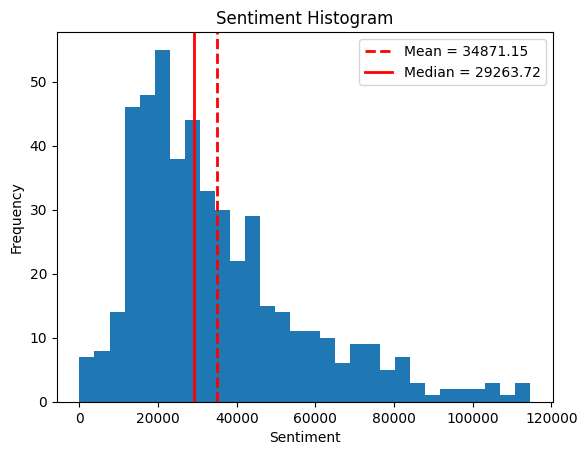

In [33]:
fig, ax = plt.subplots()
ax.hist(sentiments, bins=30)
ax.axvline(mean_sent, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_sent:.2f}")
ax.axvline(median_sent, color='red', linestyle='-', linewidth=2, label=f"Median = {median_sent:.2f}")

ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_title("Sentiment Histogram")

ax.legend()
plt.show()

> * Who are the 10 artists with happiest and saddest pages?

In [32]:
sotred_pages = sorted(graph.nodes, key=lambda x: graph.nodes[x]['sentiment'], reverse=True)

happiest_pages = sotred_pages[:10]
saddest_pages = sotred_pages[-10:]

print("Happiest pages:")
for page in happiest_pages:
    print(f"- {page}")

print("\nSaddest pages:")
for page in saddest_pages:
    print(f"- {page}")

Happiest pages:
- bob dylan
- paul mccartney
- queen (band)
- the beach boys
- the rolling stones
- guns n' roses
- the beatles
- u2
- elvis presley
- david bowie

Saddest pages:
- john mayall & the bluesbreakers
- parliament (band)
- the boxtones
- manfred mann chapter three
- the b-52's
- jet (australian band)
- dallas green (musician)
- poison (american band)
- van zant (band)
- dr. hook & the medicine show
